##Imports, downloads

In [2]:
import functools
from dataclasses import dataclass
import os
from glob import glob
import sys
import argparse

import numpy as np
import pandas as pd
import random

import torch
import torchvision
from torch import nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, ColorJitter
from torchvision.transforms import RandomCrop, RandomRotation, RandomHorizontalFlip, RandomVerticalFlip
from torchvision.models import resnet18

import tqdm
from tqdm.auto import tqdm, trange
from sklearn.metrics import accuracy_score

from google.colab import drive
drive.mount('/content/drive')

from IPython.core.display import clear_output
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import albumentations as A
from sklearn import metrics

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install wandb
!wandb login
import wandb
clear_output()

In [3]:
!unrar x "drive/MyDrive/Colab Notebooks/task_audio/train.part1.rar"
clear_output()

In [4]:
!unrar x "drive/MyDrive/Colab Notebooks/task_audio/val.rar"
clear_output()

In [3]:
ROOT_MODEL = "./drive/MyDrive/Colab Notebooks/task_audio"

##Dataset, dataloader

In [4]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_random_seed(42)

In [5]:
@dataclass(frozen=True)
class PairedDataset(Dataset):
    dirname: str
    transform: torchvision.transforms
    extension: str = "npy"
    clean: str = "clean"
    noisy: str = "noisy"

    @property
    @functools.lru_cache(1)
    def files(self):
        clean_files = glob(
            f"{self.dirname}/{self.clean}/**/*.{self.extension}", recursive=True
        )
        noisy_files = [
            f"{self.dirname}/{self.noisy}{f.split(self.clean)[1]}" for f in clean_files
        ]
        return list(zip(clean_files, noisy_files))

    def __len__(self):
        return len(self.files)

    def _load_raw(self, filename: str):
        return torch.from_numpy(np.load(filename)).unsqueeze(0)

    def _check_shape(self, img):
        if img.shape[1] < 80:
            n_repeats = 80 // img.shape[1] + 1
            img = img.repeat(1, n_repeats, 1)    
        return img

    def __getitem__(self, idx):
        clean_file, noisy_file = self.files[idx]

        clean_mel = self._load_raw(clean_file)
        noisy_mel = self._load_raw(noisy_file)

        clean_mel = self._check_shape(clean_mel)
        noisy_mel = self._check_shape(noisy_mel)
        
        pair = torch.cat((clean_mel, noisy_mel), 0)
        transformed_pair = self.transform(pair)

        return transformed_pair[0].unsqueeze(0), transformed_pair[1].unsqueeze(0)

In [30]:
def get_arg_parser():
    parser = argparse.ArgumentParser()

    parser.add_argument("--batch-size", type=int, default=32)
    parser.add_argument("--growth-rate", type=int, default=16)
    parser.add_argument("--kernel-size", type=int, default=3)
    parser.add_argument("--lr", type=float, default=1e-3)
    parser.add_argument("--num-blocks", type=int, default=20)
    parser.add_argument("--num-channels", type=int, default=1)
    parser.add_argument("--num-epochs", type=int, default=80)
    parser.add_argument("--num-features", type=int, default=16)
    parser.add_argument("--num-layers", type=int, default=6)
    parser.add_argument("--seed", type=int, default=42)

    return parser

args = get_arg_parser().parse_args(args=[])

In [32]:
train_transform = Compose(
        [
            RandomCrop(size= (80, 80))
        ]            
    )
val_transform = Compose(
        [
            RandomCrop(size=(80, 80))
        ]
    )

train_dataset = PairedDataset("train/train", train_transform)#, train_transform)
val_dataset = PairedDataset("val/val", val_transform)#, train_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = args.batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = args.batch_size, shuffle = True)

In [33]:
a , b = next(iter(train_dataloader))
assert a.shape == torch.Size([args.batch_size, 1, 80, 80]) == b.shape
print("test passed")

test passed


##Model

In [15]:
# Inspired by https://github.com/aptlin/audio-denoising
# Adapted from the PyTorch implementation of Residual Dense Network
# for Image Super-Resolution by @yjn870,
# https://github.com/yjn870/RDN-pytorch

class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) // 2,
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return torch.cat([x, self.relu(self.conv(x))], 1)


class ResidualDenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, num_layers):
        super().__init__()
        self.dense_layers = nn.Sequential(
            *[
                DenseLayer(in_channels + growth_rate * layer_idx, growth_rate)
                for layer_idx in range(num_layers)
            ]
        )

        self.local_feature_fusion = nn.Conv2d(
            in_channels + growth_rate * num_layers, in_channels, kernel_size=1,
        )

    def forward(self, x):
        return x + self.local_feature_fusion(self.dense_layers(x))


class ResidualDenseNetwork(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.kernel_size = args.kernel_size
        self.num_channels = args.num_channels
        self.growth_rate = args.growth_rate
        self.num_features = args.num_features
        self.num_blocks = args.num_blocks
        self.num_layers = args.num_layers

        self.outer_shallow_features = nn.Conv2d(
            self.num_channels,
            self.num_features,
            kernel_size=self.kernel_size,
            padding=(self.kernel_size - 1) // 2,
        )
        self.inner_shallow_features = nn.Conv2d(
            self.num_features,
            self.num_features,
            kernel_size=self.kernel_size,
            padding=(self.kernel_size - 1) // 2,
        )

        self.residual_dense_blocks = nn.ModuleList(
            [
                ResidualDenseBlock(self.num_features, self.growth_rate, self.num_layers)
                for _ in range(self.num_blocks)
            ]
        )

        self.global_feature_fusion = nn.Sequential(
            nn.Conv2d(
                self.num_features * self.num_blocks, self.num_features, kernel_size=1,
            ),
            nn.Conv2d(self.num_features, self.num_features, kernel_size=3, padding=1,),
        )
        self.output = nn.Conv2d(
            self.num_features,
            self.num_channels,
            kernel_size=self.kernel_size,
            padding=(self.kernel_size - 1) // 2,
        )

    def forward(self, x):
        outer_shallow_features = self.outer_shallow_features(x)
        x = self.inner_shallow_features(outer_shallow_features)

        local_features = []
        for block_idx in range(self.num_blocks):
            x = self.residual_dense_blocks[block_idx](x)
            local_features.append(x)

        x = (
            self.global_feature_fusion(torch.cat(local_features, 1))
            + outer_shallow_features
        )
        x = self.output(x)
        return x

##Train


In [16]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0", epoch = 0):

    model = model.to(device).train()
    total_loss = 0
    num_batches = 0

    for clean, noisy in tqdm(train_dataloader, desc=f"Training, epoch {epoch}", leave=False):    
        # Move Batch to GPU
        clean = clean.to(device).float()
        noisy = noisy.to(device).float()
        predicted = model(noisy)

        loss = criterion(predicted, clean)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        num_batches += 1 


    metrics = {"train_loss": total_loss / num_batches}
    wandb.log({"train_loss": metrics["train_loss"]})


def validate(model, val_dataloader, criterion, device="cuda:0", epoch = 0, best_loss = 100):

    model = model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for clean, noisy in tqdm(val_dataloader, desc=f"Validating, epoch {epoch}", leave=False):
               
            clean = clean.to(device).float()
            noisy = noisy.to(device).float()
            predicted = model(noisy)

            loss = criterion(predicted, clean)

            total_loss += loss.item()
            num_batches += 1

        metrics = {"val_loss": total_loss / num_batches}
        wandb.log({"val_loss": metrics["val_loss"]})
        
        #Save best model
        if best_loss > metrics["val_loss"]:
            best_loss = metrics["val_loss"]
            filename_pth = ROOT_MODEL + '/mel_denoising_loss_{:.4f}_epoch_{}.pth'.format(
                round(metrics["val_loss"], 6), epoch
            )
            torch.save(model.state_dict(), filename_pth)

    return metrics["val_loss"]


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    best_loss = 100
    for epoch in range(n_epochs):
        # Train, evaluate, print metric
        train_one_epoch(model, train_dataloader, criterion, optimizer, device, epoch)
        losses = validate(model, val_dataloader, criterion, device, epoch, best_loss)
        print("val_loss: ", losses)
        if (losses < best_loss):
            best_loss = losses
        #clear_output()

In [17]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

lr = 0.001
n_epochs = 10

model = ResidualDenseNetwork(args).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr) 
criterion = nn.MSELoss()

In [36]:
wandb_config = {
  "learning_rate": lr,
  "epochs": n_epochs,
  "batch_size": args.batch_size
}

wandb.init(config = wandb_config, project="mel_denoising", entity="_bro")

train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

train_loss,▁
val_loss,█▁▅▄▇▅
train_loss,0.07114
val_loss,0.04904


Training, epoch 0:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 0:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.044981163024665816


Training, epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.04244584279755751


Training, epoch 2:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.039674925543959176


Training, epoch 3:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.037412018766478886


Training, epoch 4:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 4:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.03484599481499384


Training, epoch 5:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 5:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.031716674684532105


Training, epoch 6:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 6:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.036553223395631426


Training, epoch 7:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 7:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.0314456702224792


Training, epoch 8:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 8:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.04076854716099444


Training, epoch 9:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 9:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.0329515157888333


In [37]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs)

Training, epoch 0:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 0:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.03060588902897305


Training, epoch 1:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.0314680648051084


Training, epoch 2:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.034326904083764744


Training, epoch 3:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.031390322283619924


Training, epoch 4:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 4:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.033744048504602345


Training, epoch 5:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 5:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.03128969302726171


Training, epoch 6:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 6:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.03243179214260881


Training, epoch 7:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 7:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.0311985466156214


Training, epoch 8:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 8:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.031802329574785536


Training, epoch 9:   0%|          | 0/375 [00:00<?, ?it/s]

Validating, epoch 9:   0%|          | 0/63 [00:00<?, ?it/s]

val_loss:  0.030072837092337153


##Load model and visualize


In [18]:
model = ResidualDenseNetwork(args).to(device)
model.load_state_dict(torch.load(ROOT_MODEL + "/mel_denoising_loss_0.0301_epoch_9.pth"))

<All keys matched successfully>

In [19]:
check_clean, check_noisy = next(iter(train_dataloader))
predicted = model(check_noisy.to(device).float())

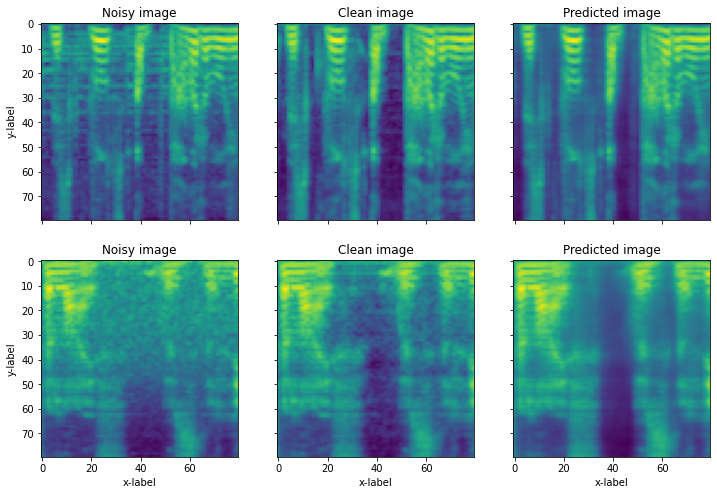

In [22]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(check_noisy[0][0].float().T)
axs[0, 0].set_title('Noisy image')
axs[0, 1].imshow(check_clean[0][0].float().T)
axs[0, 1].set_title('Clean image')
axs[0, 2].imshow(predicted[0][0].float().cpu().detach().numpy().T)
axs[0, 2].set_title('Predicted image')

axs[1, 0].imshow(check_noisy[3][0].float().T)
axs[1, 0].set_title('Noisy image')
axs[1, 1].imshow(check_clean[3][0].float().T)
axs[1, 1].set_title('Clean image')
axs[1, 2].imshow(predicted[3][0].float().cpu().detach().numpy().T)
axs[1, 2].set_title('Predicted image')

fig.set_figheight(8)
fig.set_figwidth(12)

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()